For a given time period averages rates between all of the sources and destinations and plots it.

In [1]:
%matplotlib inline
from datetime import datetime
import numpy as np
import math
from elasticsearch import Elasticsearch, exceptions as es_exceptions
import matplotlib.pyplot as plt
from scipy.cluster.hierarchy import dendrogram, linkage

currentTime=int(round(datetime.utcnow().timestamp()* 1000))
lastHours=96
startTime=currentTime - lastHours*3600000 
endTime=currentTime

In [2]:
es = Elasticsearch([{'host':'atlas-kibana.mwt2.org', 'port':9200}])

#constants
searchString={
    "size":0,
    "query":{
        "filtered":{
            "query":{
                "query_string":{"query":"*","analyze_wildcard":True,"lowercase_expanded_terms":False}},
            "filter":{
                "range":{"timestamp":{"gte": startTime,"lte": endTime,"format": "epoch_millis"}}
            }
        }
    },
    "aggs": {"2":{"terms":{ "field":"source","size":80},
                  "aggs":{"3":{"terms":{"field":"destination","size":80},"aggs":{"1":{ "avg": { "field": "rate"}}}}}}}}

res= es.search(body=searchString)
print ('results returned in: ',res['took'], 'ms')
r=res['aggregations']['2']['buckets']
#print (r)

results returned in:  1244 ms


Processing results

In [3]:
AllData={}
srcs=set()
dests=set()
for s in r:
#   print ('source:', s['key'])
    srcs.add(s['key'])
    AllData[s['key']]={}
    tm=s['3']['buckets']
    for d in tm:
        dests.add(d['key'])
        AllData[s['key']][d['key']]=[d["1"]["value"],d['doc_count']]
print ("sources:", len(srcs), "destinations:",len(dests))

sites = sorted(srcs|dests)
srcs  = sorted(srcs)
dests = sorted(dests)

rate = np.zeros( (len(sites),len(sites)) )

for fi,f in enumerate(sites):
    for si,s in enumerate(sites):
        if f<s or f==s: continue
        pr=0
        npr=0
        se=0
        nse=0
        if f in AllData: 
            if s in AllData[f]:
                pr=AllData[f][s][0]
                npr=AllData[f][s][1]
        if s in AllData:
            if f in AllData[s]:
                sek=AllData[s][f][0]
                nsek=AllData[s][f][1]
        if npr+nse>0:
            rate[fi,si]=(pr*npr+se*nse)/(npr+nse)



sources: 62 destinations: 31


Find clusters

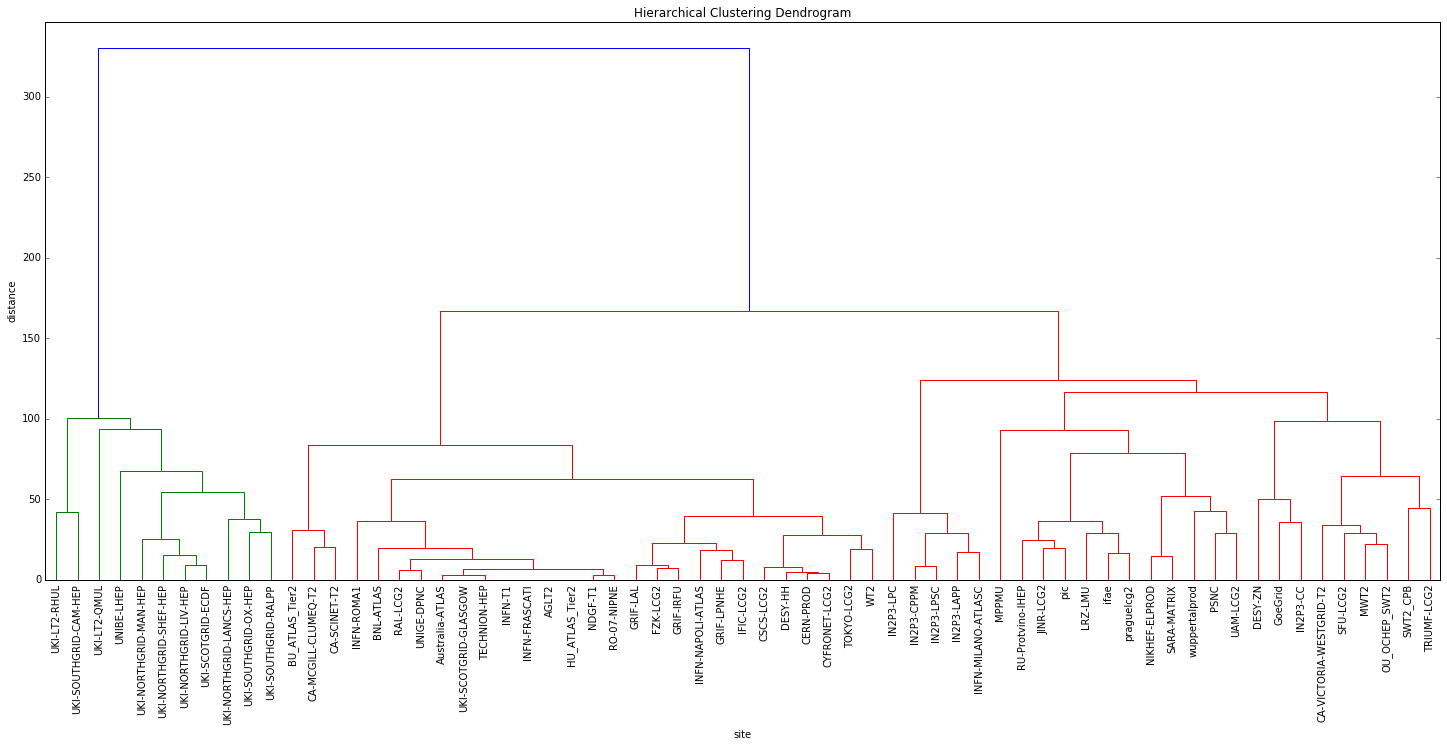

In [7]:
# generate the linkage matrix
# Z = linkage(rate, 'average')
Z = linkage(rate, 'ward')

plt.figure(figsize=(25, 10))
plt.title('Hierarchical Clustering Dendrogram')
plt.xlabel('site')
plt.ylabel('distance')
dendrogram(
    Z,
    labels=sites,
    leaf_rotation=90.,  # rotates the x axis labels
    leaf_font_size=10.,  # font size for the x axis labels
)

plt.savefig("CostMatrixClustering.png")
plt.show()